# CMS vs Baseline on Permuted-MNIST (Continual Learning)

In [2]:
import sys
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from experiments.stats import paired_ttest
from experiments.metrics import compute_avg_forgetting, compute_avg_accuracy, forgetting_matrix

RESULTS_RAW = Path("../results/raw")
RESULTS_SUMMARY = Path("../results/summary.json")
FIG_DIR = Path("../results/figures")

In [3]:
# --- Load saved runs ---
files = sorted(RESULTS_RAW.glob("seed_*.npz"))
assert len(files) > 0, f"No .npz files found in {RESULTS_RAW.resolve()}"

A_base_runs, A_cms_runs, seeds = [], [], []
for f in files:
    d = np.load(f)
    A_base_runs.append(d["acc_baseline"])
    A_cms_runs.append(d["acc_cms"])
    seeds.append(int(f.stem.split("_")[1]))

A_base_runs = np.array(A_base_runs)  # (R, T, T)
A_cms_runs  = np.array(A_cms_runs)

R, T, _ = A_base_runs.shape
print(f"Loaded {R} runs, T={T} tasks. Seeds: {seeds[:10]}{'...' if len(seeds)>10 else ''}")


Loaded 5 runs, T=10 tasks. Seeds: [0, 1, 2, 3, 4]


In [5]:
# --- compute per-run metrics (paired samples) ---
base_acc = np.array([compute_avg_accuracy(A) for A in A_base_runs])
cms_acc  = np.array([compute_avg_accuracy(A) for A in A_cms_runs])
base_forget = np.array([compute_avg_forgetting(A) for A in A_base_runs])
cms_forget  = np.array([compute_avg_forgetting(A) for A in A_cms_runs])

print("Avg accuracy per run (baseline):   ", base_acc)
print("Avg accuracy per run (cms):        ", cms_acc)
print("Avg forgetting per run (baseline): ", base_forget)
print("Avg forgetting per run (cms):      ", cms_forget)

Avg accuracy per run (baseline):    [0.50652999 0.46223003 0.50783998 0.48519    0.50873005]
Avg accuracy per run (cms):         [0.56549001 0.58166999 0.56197    0.56296003 0.61251003]
Avg forgetting per run (baseline):  [0.5214889  0.56937772 0.51950002 0.5451889  0.51936662]
Avg forgetting per run (cms):       [0.45223337 0.43283334 0.45513332 0.45525557 0.39952222]


In [6]:
# --- summary (mean ± std) ---
def mean_std(x):
    x = np.asarray(x)
    mean = float(x.mean())
    std = float(x.std(ddof=1)) if len(x) > 1 else 0.0
    return mean, std

mA_b, sA_b = mean_std(base_acc)
mA_c, sA_c = mean_std(cms_acc)
mF_b, sF_b = mean_std(base_forget)
mF_c, sF_c = mean_std(cms_forget)

print("======= Summary (mean ± std) =======")
print(f"Accuracy   Baseline: {mA_b*100:6.2f}% ±{sA_b*100:5.2f}%")
print(f"Accuracy   CMS     : {mA_c*100:6.2f}% ±{sA_c*100:5.2f}%")
print(f"Forgetting Baseline: {mF_b*100:6.2f}% ±{sF_b*100:5.2f}%")
print(f"Forgetting CMS     : {mF_c*100:6.2f}% ±{sF_c*100:5.2f}%")


======= Summary (mean ± std) =======
Accuracy   Baseline:  49.41% ± 2.03%
Accuracy   CMS     :  57.69% ± 2.14%
Forgetting Baseline:  53.50% ± 2.21%
Forgetting CMS     :  43.90% ± 2.40%


In [11]:
# --- paired statistical tests ---
tF, pF = paired_ttest(base_forget, cms_forget)
tA, pA = paired_ttest(base_acc, cms_acc)
print("================= Paired tests =================")
print(f"Forgetting: t={tF:.3f}, p={pF:.6f} (baseline - cms)")
print(f"Accuracy  : t={tA:.3f}, p={pA:.6f} (baseline - cms)")

================= Paired tests =================
Forgetting: t=6.817, p=0.002420 (baseline - cms)
Accuracy  : t=-6.549, p=0.002811 (baseline - cms)


## Plots

In [ ]:
def show_figure(path):
    img = Image.open(path)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

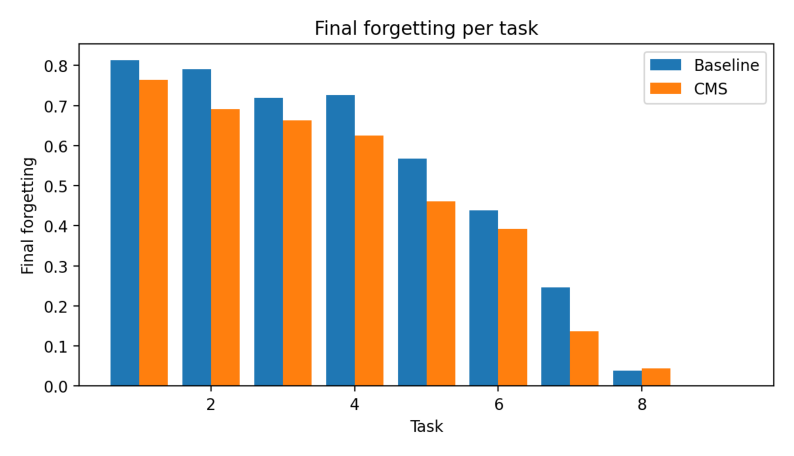

In [29]:
show_figure(FIG_DIR / "final_forgetting_per_task.png")

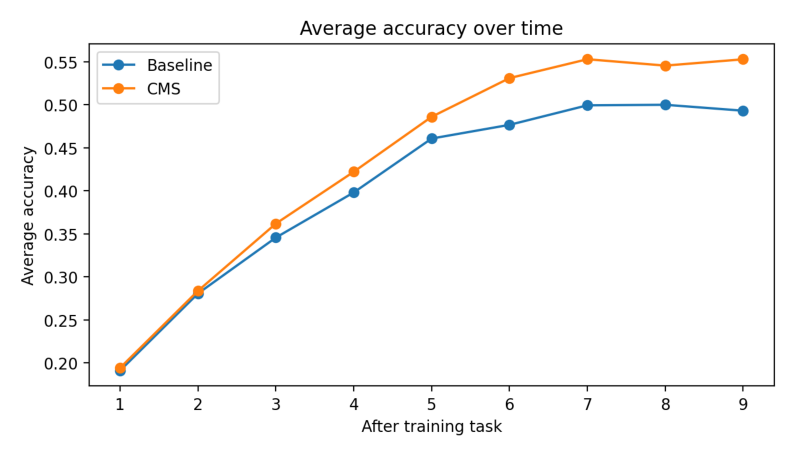

In [30]:
show_figure(FIG_DIR / "avg_accuracy_over_time.png")

## Optional deeper diagnostics

The following cell is optional. It produces denser plots that are useful for debugging, not for a LinkedIn post.


In [ ]:
# Optional: if you kept the grid-style plots in experiments/plots.py, you can call them here.
# from experiments.plots import plot_accuracy_evolution, plot_task_forgetting, plot_cumulative_forgetting
# plot_accuracy_evolution(A_base_mean, A_cms_mean, max_cols=3)
# plot_task_forgetting(F_base_mean, F_cms_mean, max_cols=3)
# plot_cumulative_forgetting(F_base_mean, F_cms_mean, max_cols=3)

## Notes

- This notebook uses your repo helpers (`experiments/metrics.py`, `experiments/stats.py`) when available.
- If a helper is missing, it falls back to a small local implementation so the notebook still runs.
